In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Data

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,.224,0.225]) ## mean and std for imagenet datset
])

In [4]:
dataset = datasets.ImageFolder(root = "./dataset" , transform=image_transforms)
len(dataset)

2300

In [22]:
class_names =dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [6]:
num_classes = len(dataset.classes)
num_classes

6

In [7]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [8]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [11]:
images[1].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


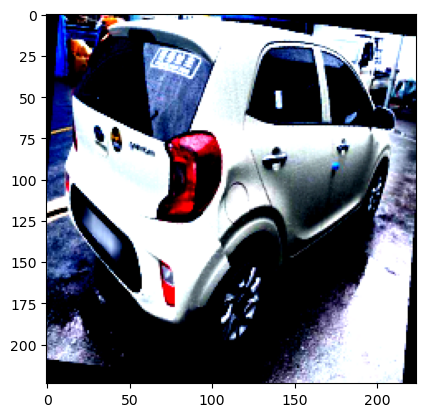

In [12]:
plt.imshow(images[1].permute(1,2,0)) 
plt.show()

In [13]:
labels[1]

tensor(4)

## CNN

In [14]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels = 16, kernel_size = 3 , stride =1,padding =1), ## out (16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (16,112,112)
            nn.Conv2d(in_channels=16,out_channels = 32, kernel_size = 3 , stride =1,padding =1), ## out (32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),## out (32,56,56)
            nn.Conv2d(in_channels=32,out_channels = 64, kernel_size = 3 , stride =1,padding =1), ## out (64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),## out (64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)   
        )
    def forward (self ,x):
        x =self.network(x)
        return x

In [15]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [16]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.76
Batch: 20, Epoch: 1, Loss: 1.80
Batch: 30, Epoch: 1, Loss: 1.60
Batch: 40, Epoch: 1, Loss: 1.55
Batch: 50, Epoch: 1, Loss: 1.28
Epoch [1/10], Avg Loss: 1.7868
*** Validation Accuracy: 45.04% ***
Batch: 10, Epoch: 2, Loss: 0.98
Batch: 20, Epoch: 2, Loss: 1.32
Batch: 30, Epoch: 2, Loss: 1.27
Batch: 40, Epoch: 2, Loss: 1.14
Batch: 50, Epoch: 2, Loss: 0.83
Epoch [2/10], Avg Loss: 1.2133
*** Validation Accuracy: 50.61% ***
Batch: 10, Epoch: 3, Loss: 1.18
Batch: 20, Epoch: 3, Loss: 1.02
Batch: 30, Epoch: 3, Loss: 1.17
Batch: 40, Epoch: 3, Loss: 1.09
Batch: 50, Epoch: 3, Loss: 1.00
Epoch [3/10], Avg Loss: 1.0768
*** Validation Accuracy: 56.35% ***
Batch: 10, Epoch: 4, Loss: 1.07
Batch: 20, Epoch: 4, Loss: 1.10
Batch: 30, Epoch: 4, Loss: 0.98
Batch: 40, Epoch: 4, Loss: 0.94
Batch: 50, Epoch: 4, Loss: 1.06
Epoch [4/10], Avg Loss: 0.9561
*** Validation Accuracy: 61.91% ***
Batch: 10, Epoch: 5, Loss: 0.86
Batch: 20, Epoch: 5, Loss: 1.07
Batch: 30, Epoch: 5, Loss: 1

## Transfer Learning with ResNet Model

In [17]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [19]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.01
Batch: 20, Epoch: 1, Loss: 0.99
Batch: 30, Epoch: 1, Loss: 0.60
Batch: 40, Epoch: 1, Loss: 0.56
Batch: 50, Epoch: 1, Loss: 0.52
Epoch [1/5], Avg Loss: 0.8460
*** Validation Accuracy: 73.74% ***
Batch: 10, Epoch: 2, Loss: 0.42
Batch: 20, Epoch: 2, Loss: 0.46
Batch: 30, Epoch: 2, Loss: 0.42
Batch: 40, Epoch: 2, Loss: 0.40
Batch: 50, Epoch: 2, Loss: 0.38
Epoch [2/5], Avg Loss: 0.5073
*** Validation Accuracy: 82.96% ***
Batch: 10, Epoch: 3, Loss: 0.88
Batch: 20, Epoch: 3, Loss: 0.36
Batch: 30, Epoch: 3, Loss: 0.16
Batch: 40, Epoch: 3, Loss: 0.37
Batch: 50, Epoch: 3, Loss: 0.38
Epoch [3/5], Avg Loss: 0.3319
*** Validation Accuracy: 77.57% ***
Batch: 10, Epoch: 4, Loss: 0.47
Batch: 20, Epoch: 4, Loss: 0.20
Batch: 30, Epoch: 4, Loss: 0.28
Batch: 40, Epoch: 4, Loss: 0.40
Batch: 50, Epoch: 4, Loss: 0.20
Epoch [4/5], Avg Loss: 0.2472
*** Validation Accuracy: 78.96% ***
Batch: 10, Epoch: 5, Loss: 0.46
Batch: 20, Epoch: 5, Loss: 0.12
Batch: 30, Epoch: 5, Loss: 0.08


## Model Evaluation using Confusion Matrix and Classification Report

In [20]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       114
           1       0.82      0.72      0.77       111
           2       0.90      0.95      0.93       131
           3       0.57      0.86      0.69        64
           4       0.85      0.63      0.72        89
           5       0.85      0.77      0.81        66

    accuracy                           0.81       575
   macro avg       0.80      0.80      0.79       575
weighted avg       0.82      0.81      0.81       575



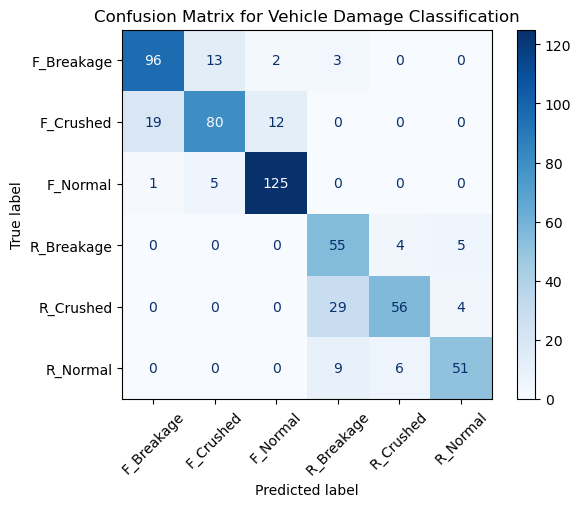

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

## Saving Model

In [24]:
torch.save(model.state_dict(), 'saved_model.pth')